# A Demo with DocumentArray

Import DocumentArray:

In [1]:
from docarray import Document, DocumentArray

Some configs:

In [2]:
DATA_DIR = "./data"
DATA_PATH = f"{DATA_DIR}/*.jpg"
MAX_DOCS = 1000
QUERY_IMAGE = "./query.jpg" # image we'll use to search with
PLOT_EMBEDDINGS = False # Really useful but have to manually stop it to progress to next cell
MODEL = "resnet101"
PRE_TRAINED = False

# Toy data - If data dir doesn't exist, we'll get data of ~800 fashion images from here
TOY_DATA_URL = "https://github.com/alexcg1/neural-search-notebooks/raw/main/fashion-search/data.zip?raw=true"

In [3]:
import os

if not os.path.isdir(DATA_DIR) and not os.path.islink(DATA_DIR):
    print(f"Can't find {DATA_DIR}. Downloading toy dataset")
    !wget "$TOY_DATA_URL" -O data.zip
    !unzip -q data.zip # Don't print out every darn filename
    !rm -f data.zip
else:
    print(f"Nothing to download. Using {DATA_DIR} for data")

Nothing to download. Using ./data for data


Use `.from_files` to quickly load them into a `DocumentArray`

In [4]:
docs = DocumentArray.from_files(DATA_PATH, size=MAX_DOCS)
print(f"{len(docs)} Documents in DocumentArray")
print(docs[1].to_dict)

845 Documents in DocumentArray
<bound method PortingMixin.to_dict of <Document ('id', 'mime_type', 'uri') at 1458c8bfccea0c84b861ad02ffe4d189>>


Preview the images


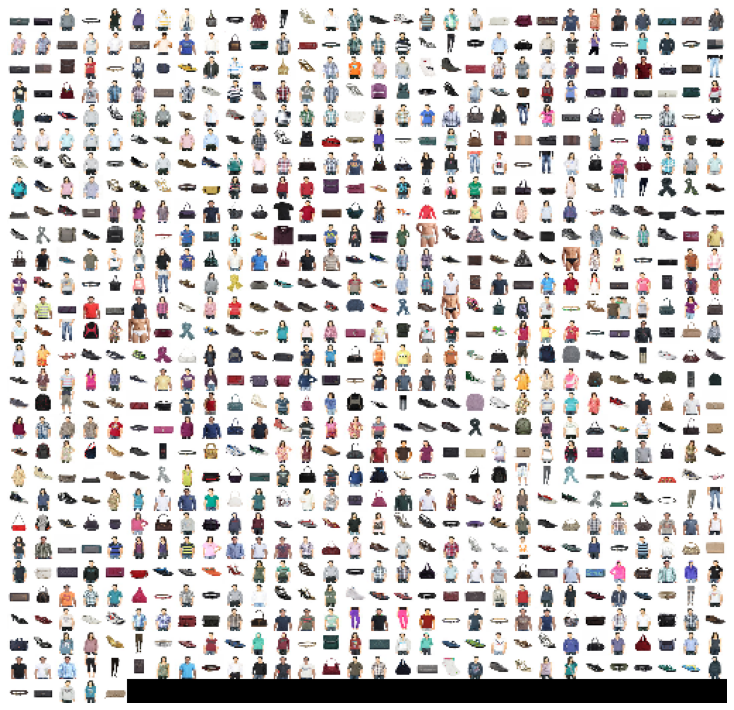

In [5]:
docs.plot_image_sprites()

Convert to tensor, normalize so they're all similar enough

In [6]:
def pre_proc(d: Document):
    return (d.load_uri_to_image_tensor()  # load
             .set_image_tensor_shape((80, 60))  # ensure all images right size (dataset image size _should_ be (80, 60))
             .set_image_tensor_normalization()  # normalize color 
             .set_image_tensor_channel_axis(-1, 0))  # switch color axis for the PyTorch model later
    
docs.apply(pre_proc)
docs

╭─────────────────────── Documents Summary ───────────────────────╮
│                                                                 │
│   Length                 845                                    │
│   Homogenous Documents   True                                   │
│   Common Attributes      ('id', 'tensor', 'mime_type', 'uri')   │
│   Multimodal dataclass   False                                  │
│                                                                 │
╰─────────────────────────────────────────────────────────────────╯
╭────────────────────── Attributes Summary ───────────────────────╮
│                                                                 │
│   Attribute   Data type      #Unique values   Has empty value   │
│  ─────────────────────────────────────────────────────────────  │
│   id          ('str',)       845              False             │
│   mime_type   ('str',)       1                False             │
│   tensor      ('ndarray',)   845              False             │
│   uri         ('str',)       845              False             │
│                                                                 │
╰─────────────────────────────────────────────────────────────────╯

Build the model. With bare ResNet50.

In [7]:
import torch
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
device

/Users/zijian.liu/Documents/Files/learning/python-learning/jinaDemo/venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'cpu'

In [8]:
%pip install torchvision==0.11.2
import torchvision
resnet101 = torchvision.models.resnet101(pretrained=PRE_TRAINED)  # load ResNet101
resnet50 = torchvision.models.resnet50(pretrained=PRE_TRAINED)  # load ResNet101
alexnet = torchvision.models.alexnet(pretrained=PRE_TRAINED)  # load alexnet

if (MODEL == "resnet101"): model = resnet101 
elif (MODEL == "alexnet"): model = alexnet
else: model = resnet50

Note: you may need to restart the kernel to use updated packages.


In [9]:
docs.embed(model, device=device)

╭───────────────────────────── Documents Summary ──────────────────────────────╮
│                                                                              │
│   Length                 845                                                 │
│   Homogenous Documents   True                                                │
│   Common Attributes      ('id', 'tensor', 'mime_type', 'uri', 'embedding')   │
│   Multimodal dataclass   False                                               │
│                                                                              │
╰──────────────────────────────────────────────────────────────────────────────╯
╭────────────────────── Attributes Summary ───────────────────────╮
│                                                                 │
│   Attribute   Data type      #Unique values   Has empty value   │
│  ─────────────────────────────────────────────────────────────  │
│   embedding   ('Tensor',)    845              False             │
│   id          ('str',)       845              False             │
│   mime_type   ('str',)       1                False             │
│   tensor      ('ndarray',)   845              False             │
│   uri         ('str',)       845              False             │
│                                                                 │
╰─────────────────────────────────────────────────────────────────╯

In [10]:
if PLOT_EMBEDDINGS:
    docs.plot_embeddings(image_sprites=True, image_source="uri")

Get the query document and do the same process as before.

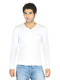

In [11]:
# Download query doc
if not os.path.exists('./query.jpg'):
    !wget https://github.com/alexcg1/neural-search-notebooks/raw/main/fashion-search/1_build_basic_search/query.jpg -O query.jpg

query_doc = Document(uri=QUERY_IMAGE)
query_doc.display()

In [12]:
# Throw the one Document into a DocumentArray, since that's what we're matching against
query_docs = DocumentArray([query_doc])

In [13]:
# Apply same preprocessing
query_docs.apply(pre_proc)

╭─────────────────────── Documents Summary ───────────────────────╮
│                                                                 │
│   Length                 1                                      │
│   Homogenous Documents   True                                   │
│   Common Attributes      ('id', 'tensor', 'mime_type', 'uri')   │
│   Multimodal dataclass   False                                  │
│                                                                 │
╰─────────────────────────────────────────────────────────────────╯
╭────────────────────── Attributes Summary ───────────────────────╮
│                                                                 │
│   Attribute   Data type      #Unique values   Has empty value   │
│  ─────────────────────────────────────────────────────────────  │
│   id          ('str',)       1                False             │
│   mime_type   ('str',)       1                False             │
│   tensor      ('ndarray',)   1                False             │
│   uri         ('str',)       1                False             │
│                                                                 │
╰─────────────────────────────────────────────────────────────────╯

In [14]:
# ...and create embedding just like we did with the dataset
query_docs.embed(model, device=device) # If running on non-gpu machine, change "cuda" to "cpu"

╭───────────────────────────── Documents Summary ──────────────────────────────╮
│                                                                              │
│   Length                 1                                                   │
│   Homogenous Documents   True                                                │
│   Common Attributes      ('id', 'tensor', 'mime_type', 'uri', 'embedding')   │
│   Multimodal dataclass   False                                               │
│                                                                              │
╰──────────────────────────────────────────────────────────────────────────────╯
╭────────────────────── Attributes Summary ───────────────────────╮
│                                                                 │
│   Attribute   Data type      #Unique values   Has empty value   │
│  ─────────────────────────────────────────────────────────────  │
│   embedding   ('Tensor',)    1                False             │
│   id          ('str',)       1                False             │
│   mime_type   ('str',)       1                False             │
│   tensor      ('ndarray',)   1                False             │
│   uri         ('str',)       1                False             │
│                                                                 │
╰─────────────────────────────────────────────────────────────────╯

Do the MATCH.

In [15]:
query_docs.match(docs, limit=9)

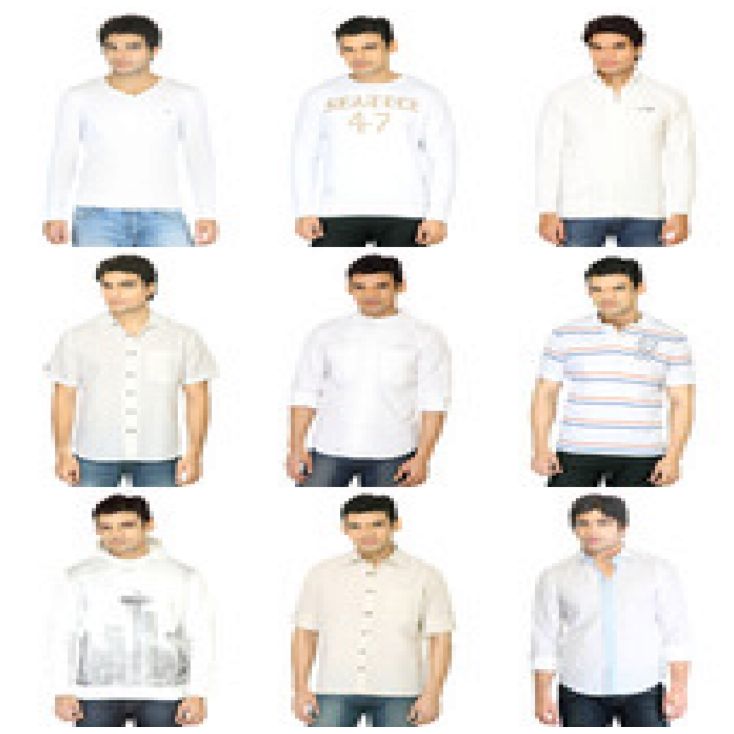

In [16]:
(DocumentArray(query_doc.matches, copy=True)
    .apply(lambda d: d.set_image_tensor_channel_axis(0, -1)
                      .set_image_tensor_inv_normalization())
    ).plot_image_sprites()

In [17]:
if PLOT_EMBEDDINGS:
    query_doc.matches.plot_embeddings(image_sprites=True, image_source="uri")